In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from deap import base, creator, tools, algorithms

# Define the DataFrame
data = {
    'type': ['objective', 'constraint1', 'constraint2', 'constraint3', 'constraint4', 
             'constraint5', 'constraint6', 'constraint7', 'constraint8','constraint9'],
    'x11': [2400, 1, 0, 0,0, 1,0,1,1,0],
    'x12': [2500, 0, 1, 0,0, 0,1,1,1,0],
    'x21': [2000, 0, 0, 1,0, 1,0,1,0,1],
    'x22': [1900, 0, 0, 0,1, 0,1,1,0,1],
    'RHS': [0,30,30,50,50,70,70,100,40,60],
    'inequality': ['','<=' ,'<=', '<=', '<=' ,'<=','<=','=','=','=']
}

df = pd.DataFrame(data)
print(df)


          type   x11   x12   x21   x22  RHS inequality
0    objective  2400  2500  2000  1900    0           
1  constraint1     1     0     0     0   30         <=
2  constraint2     0     1     0     0   30         <=
3  constraint3     0     0     1     0   50         <=
4  constraint4     0     0     0     1   50         <=
5  constraint5     1     0     1     0   70         <=
6  constraint6     0     1     0     1   70         <=
7  constraint7     1     1     1     1  100          =
8  constraint8     1     1     0     0   40          =
9  constraint9     0     0     1     1   60          =


# Linear Programming

In [11]:
import pulp

prob = pulp.LpProblem("Minimize_Profit", pulp.LpMinimize)

# Define the decision variables
x11 = pulp.LpVariable('x11', lowBound=0, cat='Continuous')
x12 = pulp.LpVariable('x12', lowBound=0, cat='Continuous')
x21 = pulp.LpVariable('x21', lowBound=0, cat='Continuous')
x22 = pulp.LpVariable('x22', lowBound=0, cat='Continuous')

# Objective function
prob += 2400*x11 + 2500*x12 + 2000*x21 + 1900*x22, "Total Cost"

# Constraints
prob += x11 <= 30, "Constraint 1"
prob += x12 <= 30, "Constraint 2"
prob += x21 <= 50, "Constraint 3"
prob += x22 <= 50, "Constraint 4"
prob += x11 + x21 <= 70, "Constraint 5"
prob += x12 + x22 <= 70, "Constraint 6"
prob += x11 + x12 + x21 + x22 == 100, "Constraint 7"
prob += x11 + x12 == 40, "Constraint 8"
prob += x21 + x22 == 60, "Constraint 9"

prob.solve()
print("Status:", pulp.LpStatus[prob.status])
print("x11 =", pulp.value(x11))
print("x12 =", pulp.value(x12))
print("x21 =", pulp.value(x21))
print("x22 =", pulp.value(x22))
print("Total Cost = ", pulp.value(prob.objective))


Status: Optimal
x11 = 30.0
x12 = 10.0
x21 = 10.0
x22 = 50.0
Total Cost =  212000.0


# Genetic Algorithm

In [13]:
import random
from deap import base, creator, tools, algorithms
random.seed(42)
np.random.seed(42)

# Problem parameters
LOWER_BOUND = [0, 0, 0, 0]
UPPER_BOUND = [30, 30, 50, 50]
NUM_GENES = 4

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 50)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, NUM_GENES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define the evaluation function
def evaluate(individual):
    x11, x12, x21, x22 = individual
    
    # Objective function
    cost = 2400 * x11 + 2500 * x12 + 2000 * x21 + 1900 * x22
    
    # Constraints
    penalties = 0
    if not (0 <= x11 <= 30):
        penalties += abs(x11 - 30 if x11 > 30 else x11)
    if not (0 <= x12 <= 30):
        penalties += abs(x12 - 30 if x12 > 30 else x12)
    if not (0 <= x21 <= 50):
        penalties += abs(x21 - 50 if x21 > 50 else x21)
    if not (0 <= x22 <= 50):
        penalties += abs(x22 - 50 if x22 > 50 else x22)
    if not (x11 + x21 <= 70):
        penalties += abs((x11 + x21) - 70)
    if not (x12 + x22 <= 70):
        penalties += abs((x12 + x22) - 70)
    if not (x11 + x12 + x21 + x22 == 100):
        penalties += abs((x11 + x12 + x21 + x22) - 100)
    if not (x11 + x12 == 40):
        penalties += abs((x11 + x12) - 40)
    if not (x21 + x22 == 60):
        penalties += abs((x21 + x22) - 60)
    
    penalty_cost = 1e6 * penalties  
    
    return cost + penalty_cost,

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, low=LOWER_BOUND, up=UPPER_BOUND, eta=1.0, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

population_size = 100
num_generations = 50
crossover_probability = 0.7
mutation_probability = 0.2

population = toolbox.population(n=population_size)

algorithms.eaSimple(population, toolbox, cxpb=crossover_probability, mutpb=mutation_probability, ngen=num_generations, verbose=False)


best_individual = tools.selBest(population, 1)[0]

# Print the best solution
print("Best individual is: [%.2f, %.2f, %.2f, %.2f]" % (best_individual[0], best_individual[1], best_individual[2], best_individual[3]))
print("With cost: %.2f" % evaluate(best_individual)[0])
print("x11 = %.2f" % best_individual[0])
print("x12 = %.2f" % best_individual[1])
print("x21 = %.2f" % best_individual[2])
print("x22 = %.2f" % best_individual[3])

Best individual is: [21.86, 18.14, 12.51, 47.49]
With cost: 213423.68
x11 = 21.86
x12 = 18.14
x21 = 12.51
x22 = 47.49


In [18]:
LOWER_BOUND = [0, 0, 0, 0]
UPPER_BOUND = [30, 30, 50, 50]
NUM_GENES = 4

# Genetic Algorithm parameters
population_size = 100
num_generations = 50
crossover_probability = 0.7
mutation_probability = 0.2

# Set up the GA
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 50)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, NUM_GENES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Evaluation function (as defined in your original code)
def evaluate(individual):
    x11, x12, x21, x22 = individual
    
    # Objective function
    cost = 2400 * x11 + 2500 * x12 + 2000 * x21 + 1900 * x22
    
    # Constraints
    penalties = 0
    if not (0 <= x11 <= 30): penalties += abs(x11 - 30 if x11 > 30 else x11)
    if not (0 <= x12 <= 30): penalties += abs(x12 - 30 if x12 > 30 else x12)
    if not (0 <= x21 <= 50): penalties += abs(x21 - 50 if x21 > 50 else x21)
    if not (0 <= x22 <= 50): penalties += abs(x22 - 50 if x22 > 50 else x22)
    if not (x11 + x21 <= 70): penalties += abs((x11 + x21) - 70)
    if not (x12 + x22 <= 70): penalties += abs((x12 + x22) - 70)
    if not (x11 + x12 + x21 + x22 == 100): penalties += abs((x11 + x12 + x21 + x22) - 100)
    if not (x11 + x12 == 40): penalties += abs((x11 + x12) - 40)
    if not (x21 + x22 == 60): penalties += abs((x21 + x22) - 60)
    
    penalty_cost = 1e6 * penalties
    return cost + penalty_cost,

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, low=LOWER_BOUND, up=UPPER_BOUND, eta=1.0, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Function to calculate population diversity
def population_diversity(population):
    return np.std([ind.fitness.values[0] for ind in population])

# Set up statistics and logbook
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("std", np.std)

logbook = tools.Logbook()
logbook.header = ["gen", "evals"] + stats.fields

# Create initial population
population = toolbox.population(n=population_size)

# Run the GA
for gen in range(num_generations):
    offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_probability, mutpb=mutation_probability)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))
    
    # Record statistics
    record = stats.compile(population)
    logbook.record(gen=gen, evals=len(population), **record)
    
    # Calculate and record diversity
    diversity = population_diversity(population)
    if 'diversity' not in logbook.chapters:
        logbook.chapters['diversity'] = tools.Logbook()
    logbook.chapters['diversity'].record(gen=gen, diversity=diversity)

# Extract data from logbook
gen = logbook.select("gen")
fit_mins = logbook.select("min")
fit_avgs = logbook.select("avg")
fit_maxs = logbook.select("max")
diversities = logbook.chapters["diversity"].select("diversity")

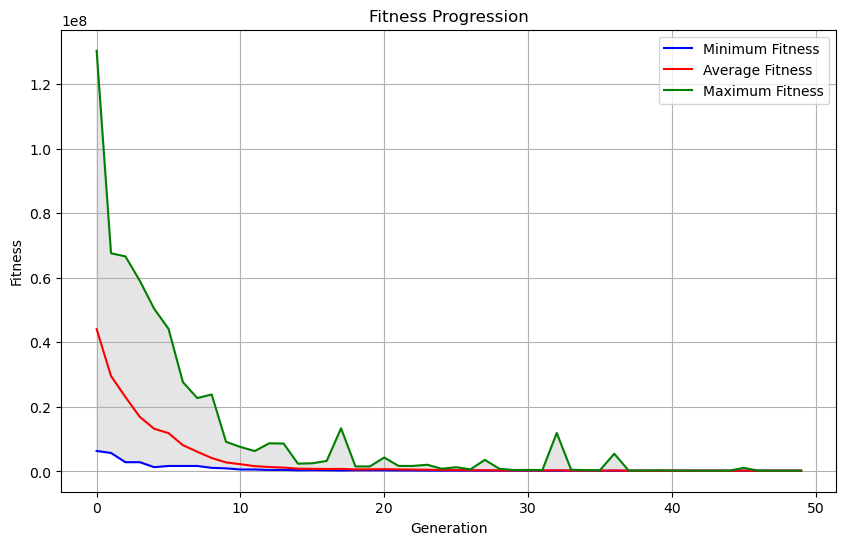

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(gen, fit_mins, 'b-', label='Minimum Fitness')
plt.plot(gen, fit_avgs, 'r-', label='Average Fitness')
plt.plot(gen, fit_maxs, 'g-', label='Maximum Fitness')
plt.fill_between(gen, fit_mins, fit_maxs, alpha=0.2, color='gray')
plt.title('Fitness Progression')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='best')
plt.grid(True)
plt.show()